In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

In [9]:
# Load Tweet dataset
df = pd.read_csv('Twitter_Data.csv')
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
#Check null  values
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [11]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [12]:
# dimensionality of the data
df.shape

(162969, 2)

In [13]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


### Data visualization

In [15]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

# word cloud of Positive & Negative 

In [16]:
from wordcloud import WordCloud, STOPWORDS

def wolrdcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

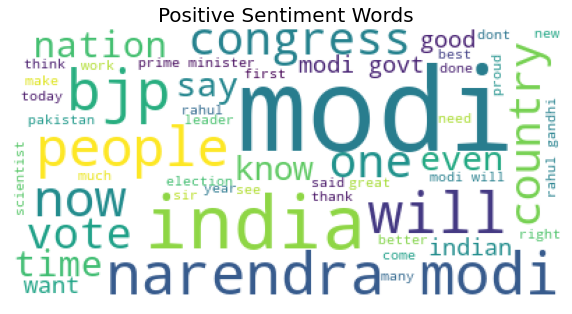

In [17]:
# Positive tweet words
wolrdcount_gen(df, 'Positive')

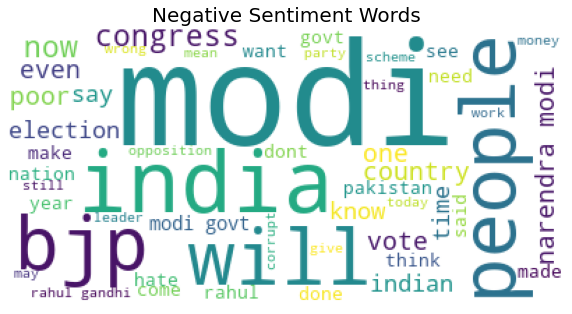

In [18]:
# Negative tweet words
wolrdcount_gen(df, 'Negative')

### Tokenizing & Padding

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Train & Test Split

In [20]:
# Convert categorical variable into dummy/indicator variables.
y = pd.get_dummies(df['category'])
# Train and Test split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Extracting validation set from the train set
valid_size=1000
X_valid, y_valid = X_train[-valid_size:], y_train[-valid_size:]
X_test, y_test = X_train[:-valid_size], y_train[:-valid_size]

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_valid.shape, y_valid.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (114078, 50) (114078, 3)
Validation Set -> (1000, 50) (1000, 3)
Test Set -> (113078, 50) (113078, 3)


In [21]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### CNN 

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from keras.metrics import Precision, Recall


vocab_size = 5000
embedding_size = 32

# Build model
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_size, input_length=max_len))
                     
model3.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))

model3.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))

model3.add(GlobalMaxPooling1D())

model3.add(Dropout(0.4))
model3.add(Dense(3, activation='softmax'))

print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            2080      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0

In [23]:
# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

In [24]:
# Train model
num_epochs = 10
batch_size = 32
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_valid, y_valid),
                      batch_size=batch_size, epochs=num_epochs)

# Evaluate model on the test set
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test)
# Print metrics
print('')
print('CNN   : {:.4f}'.format(accuracy))
print('CNN   : {:.4f}'.format(precision))
print('CNN   : {:.4f}'.format(recall))
print('CNN   : {:.4f}'.format(f1_score(precision, recall)))

Epoch 1/10
3565/3565 [==============================] - 23s 6ms/step - loss: 0.4579 - accuracy: 0.8400 - precision: 0.8808 - recall: 0.7951 - val_loss: 0.2348 - val_accuracy: 0.9340 - val_precision: 0.9340 - val_recall: 0.9340
Epoch 2/10
3565/3565 [==============================] - 23s 6ms/step - loss: 0.2838 - accuracy: 0.9220 - precision: 0.9247 - recall: 0.9185 - val_loss: 0.1903 - val_accuracy: 0.9470 - val_precision: 0.9479 - val_recall: 0.9460
Epoch 3/10
3565/3565 [==============================] - 22s 6ms/step - loss: 0.2535 - accuracy: 0.9304 - precision: 0.9328 - recall: 0.9275 - val_loss: 0.1703 - val_accuracy: 0.9510 - val_precision: 0.9520 - val_recall: 0.9510
Epoch 4/10
3565/3565 [==============================] - 24s 7ms/step - loss: 0.2284 - accuracy: 0.9375 - precision: 0.9396 - recall: 0.9350 - val_loss: 0.1384 - val_accuracy: 0.9630 - val_precision: 0.9630 - val_recall: 0.9620
Epoch 5/10
3565/3565 [==============================] - 23s 6ms/step - loss: 0.2103 - accura

In [25]:
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1_score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9768
Precision : 0.9782
Recall    : 0.9758
F1_score  : 0.9770


#### Model Accuracy & Loss

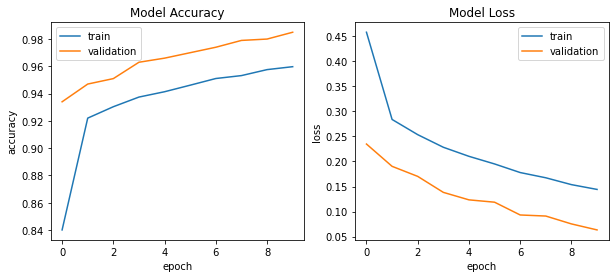

In [26]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history3)


In [27]:
##predict

predict_x=model3.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)
print(y_pred)

[1 1 0 ... 1 1 1]


#### Model Confusion Matrix

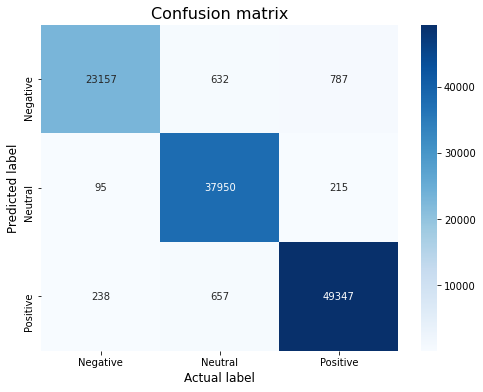

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model3, X_test, y_test)

In [44]:
from sklearn.metrics import accuracy_score, classification_report

In [55]:
#np.array(y_test)
y_111 = np.array(y_test)

In [58]:
y_test=np.argmax(y_111, axis =1)

In [62]:
y_test

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [60]:
y_pred = model3.predict(X_test)

In [64]:
#y_pred
p=np.argmax(y_pred, axis =1)
p

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [65]:
#Classification report
print(classification_report(y_test, p, digits=5))

              precision    recall  f1-score   support

           0    0.98582   0.94226   0.96355     24576
           1    0.96715   0.99190   0.97937     38260
           2    0.98010   0.98219   0.98114     50242

    accuracy                        0.97679    113078
   macro avg    0.97769   0.97211   0.97469    113078
weighted avg    0.97696   0.97679   0.97672    113078



In [29]:
y_test

,Negative,Neutral,Positive
17860,0,1,0
140395,0,1,0
116223,1,0,0
21854,1,0,0
26107,0,1,0
...,...,...,...
115034,0,0,1
131888,0,0,1
55319,0,1,0
144073,0,1,0


In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np
# Get the confusion matrix
#cm = confusion_matrix(y_test, y_pred)
y_pred = model3.predict(X_test)
cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

In [34]:
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [35]:
#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.94226074, 0.99189754, 0.98218622])

In [42]:
label = dict(zip(label_encoder.classes_,cm_diag ))
label # printing class-wise accuracy

Negative: 0.94226074
Neutral: 0.99189754
Positive: 0.98218622


In [36]:
cm_diag = cm.diagonal()
type(cm_diag)

numpy.ndarray

In [ ]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [ ]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

In [41]:
y.shape

(162969, 3)

In [39]:
#Mapping of target classes using label-encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)
le_name_mapping = dict(zip(label_encoder.classes_, cm_diag))
print(le_name_mapping)

TypeError: LabelEncoder() takes no arguments

##### Accuracy Class-wise

In [ ]:

label = dict(zip(label_encoder.classes_,cm_diag ))
label # printing class-wise accuracy

### Model save and load for the prediction

In [30]:
# Save the model architecture & the weights
model3.save('Sentiment_Analysis_CNN_best_model.h5')
print('Best model saved')

Best model saved


In [31]:
from keras.models import load_model

# Load model
model = load_model('Sentiment_Analysis_CNN_best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]]) 

In [32]:
predict_class(['Govt is unable to control rising petrol prices'])

The predicted sentiment is Negative


In [33]:
predict_class(['Govt spending on rural school education increased this year'])

The predicted sentiment is Neutral


In [34]:
predict_class(['He is a best minister india ever had seen'])

The predicted sentiment is Positive
